In [162]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from timeit import timeit
import sys
import os
import seaborn
import ast

from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

In [2]:
sys.setrecursionlimit(10**8)

In [3]:
global DataFrequency

DataFrequency = '1T'

/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_786/4182715476.py:268: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  inp_data.beautiful_time = pd.date_range(pd.Timestamp(inp_data.index.min()), pd.Timestamp(inp_data.index.min()) + pd.Timedelta(f"{inp_data.shape[0] - 1}T"), freq='1T')
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.5min finished


  0%|          | 0/45 [00:00<?, ?it/s]

OPTIMAL_PARAMS:
 BuyLossPercent      1.2
BuyTakePercent      1.2
MaxHold           1862T
WindowRoll         375T
Y_STD             300.0
Name: 24, dtype: object
INSAMPLE
Total trades: 249
Total pnl 2782.175
Positive trades: 0.518
Negative trades: 0.482
Long trades: 0.558
Short trades: 0.442
StopLoss closes: 0.088
TakeProfit closes: 0.088
endPeriod closes: 0.823

OUTOFSAMPLE
Total trades: 206
Total pnl -7435.31
Positive trades: 0.466
Negative trades: 0.534
Long trades: 0.524
Short trades: 0.476
StopLoss closes: 0.005
TakeProfit closes: 0.01
endPeriod closes: 0.985



  0%|          | 0/527040 [00:00<?, ?it/s]

  0%|          | 0/493966 [00:00<?, ?it/s]

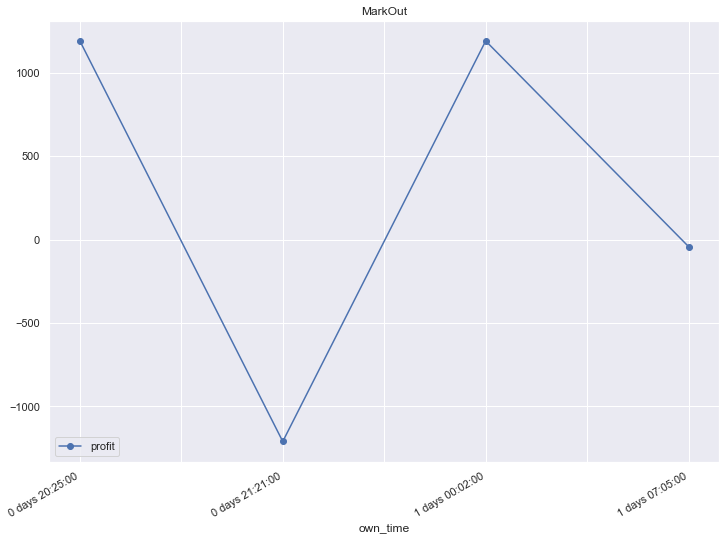

In [60]:
file_name = 'AUDCAD.csv'

PAIR_NAME = file_name.split('.')[0]
if not os.access('backTEST', os.F_OK):
    os.mkdir('backTEST')

if not os.access(f'backTEST/{PAIR_NAME}', os.F_OK):
    os.mkdir(f'backTEST/{PAIR_NAME}')

inp_data = pd.read_csv(f'testData/{file_name}', index_col=1)
# inp_data = pd.read_csv('testData/EURGBP.csv', index_col=0)
inp_data.index = pd.to_datetime(inp_data.index)

"""EURGBP columns rename"""
# inp_data.rename(columns={'Open': 'open', 'Close': 'close', 'High': 'high', 'Low': 'low'}, inplace=True)
"""DATABASE columns drop"""
inp_data.drop(['instrument', 'volume', 'average', 'barCount'], axis=1, inplace=True)

def create_grid(pam_grid_obj):
    CAP = 100_000
    slippage = 10
    BuyLossPercent = pam_grid_obj['BuyLossPercent']
    SellLossPercent = pam_grid_obj['BuyLossPercent']
    BuyTakePercent = pam_grid_obj['BuyTakePercent']
    SellTakePercent = pam_grid_obj['BuyTakePercent']
    MaxHold = pam_grid_obj['MaxHold']
    WindowRoll = pam_grid_obj['WindowRoll']
    Y_STD = pam_grid_obj['Y_STD']


    # Массив параметров
    PARAMS = {'Capital': CAP,
              'slippage': slippage,
              'slippagePerCap': slippage / CAP,
              'window_rolling': WindowRoll,
              'Y_threshold': Y_STD,
              'max_hold_period': MaxHold,
              'stopLossesPercent':{
                  'BuyLossPercent': BuyLossPercent / 100,
                  'SellLossPercent': SellLossPercent / 100,
              },
              'takePercent':{
                  'SellTakePercent': BuyTakePercent / 100,
                  'BuyTakePercent': SellTakePercent / 100,
              },
              'shift_param': int(pd.Timedelta(WindowRoll) / pd.Timedelta(DataFrequency)),
              'time_barrier_param': int(pd.Timedelta(MaxHold) / pd.Timedelta(DataFrequency))
              }
    del CAP, slippage, BuyLossPercent, SellLossPercent, BuyTakePercent, SellTakePercent, MaxHold, WindowRoll, Y_STD
    return PARAMS


def calculate_max_drawdown(PNL_SERIES, dollars=True):
    """
    solution by Marco de Prado
    :param PNL_SERIES:
    :param dollars:
    :return:
    """
    dropout_df = PNL_SERIES.to_frame('pnl')
    dropout_df['hwm'] = dropout_df.expanding().max()
    df0 = dropout_df.groupby('hwm').min().reset_index()
    df0.columns = ['hwm', 'min']
    df0 = df0[df0['hwm'] > df0['min']]
    if dollars:
        dd = df0['hwm'] - df0['min']
    else:
        dd = df0['min'] / df0['hwm']

    return max(dd)

def _estimator(data_frame, params_dict, show=False):
    DF_lines = []
    save_frame = data_frame.copy()
    # Считается параметр насколько нужно обрезать данные для адекватности сглаживания

    # Скользящее среднее
    data_frame.loc[:, 'rolling_mean'] = data_frame.loc[:, 'close'].rolling(params_dict['window_rolling']).mean()

    # Скользящее отклонение
    data_frame.loc[:, 'rolling_std'] = data_frame.loc[:, 'close'].rolling(params_dict['window_rolling']).std()

    # Отсечение данных имеющих
    # data_frame.drop(data_frame.index[:params_dict['shift_param']], axis=0, inplace=True)

    # Верхний уровень BBand
    data_frame.loc[:, 'HighBBand'] = round(data_frame.loc[:, 'rolling_mean'] + ((params_dict['Y_threshold'] / 100) * data_frame.loc[:, 'rolling_std']),5)

    # Нижний уровень BBand
    data_frame.loc[:, 'LowBBand'] = round(data_frame.loc[:, 'rolling_mean'] - ((params_dict['Y_threshold'] / 100) * data_frame.loc[:, 'rolling_std']),5)

    # Добавление номера линии для удобства
    data_frame['line_number'] = range(1, data_frame.shape[0] + 1)


    # correct_borders2 = data_frame.resample(DataFrequency).first().open.shift(-1 * params_dict['time_barrier_param']).rolling(params_dict['window_rolling']).count()
    # correct_borders = tuple(data_frame.open.shift(-1 * params_dict['time_barrier_param']).rolling(params_dict['window_rolling']).count() == float(params_dict['shift_param']))
    ab = list(zip(data_frame.copy().resample(DataFrequency).first().open.shift(-1 * params_dict['time_barrier_param'] - 1).rolling(params_dict['window_rolling']).count().values, data_frame.copy().resample(DataFrequency).first().index))
    ab = pd.DataFrame(ab)
    # print('AB',len(ab))
    # print('DF',len(data_frame))
    ab.columns = ['value', 'time']
    ab.index = ab.time
    ab = ab.drop(['time'], axis=1)

    correct_borders = tuple(pd.merge(data_frame, ab, left_index=True, right_index=True).value == params_dict['shift_param'])
    # print('CB',len(correct_borders))
    dot_low_tuple = tuple(data_frame.low)
    dot_high_tuple = tuple(data_frame.high)
    dot_close_tuple = tuple(data_frame.close)
    LowBBand_tuple = tuple(data_frame.LowBBand)
    HighBBand_tuple = tuple(data_frame.HighBBand)

    cycle_buffer = -10
    ISX = 0
    if show:
        tqdm_bar = tqdm(total=data_frame.shape[0])

    while ISX < (data_frame.shape[0] / 1.1) and (cycle_buffer != ISX):
        openLogic = OpenPosition(dot_low_tuple=dot_low_tuple, dot_high_tuple=dot_high_tuple,
                     LowBBand_tuple=LowBBand_tuple, HighBBand_tuple=HighBBand_tuple,
                     arrow_index=ISX, openParams=params_dict, correct_borders=correct_borders)

        openLogic['open_time'] = data_frame.index[openLogic['open_index']]
        closeLogic = HoldingPosition(open_logic=openLogic, dot_close_tuple=dot_close_tuple,
                        dot_high_tuple=dot_high_tuple, dot_low_tuple=dot_low_tuple,
                        holdParams=params_dict, arrow_index=openLogic['open_index'] + 1, time_border_counter=0)

        closeLogic['close_time'] = data_frame.index[closeLogic['close_index']]
        summary_dict = openLogic | closeLogic
        DF_lines.append(summary_dict)

        cycle_buffer = ISX
        ISX = closeLogic['close_index']
        if show:
            tqdm_bar.update(ISX - tqdm_bar.last_print_n)

    dfResults = pd.DataFrame(DF_lines)
    dfResults["profit"] = dfResults["position"] * (dfResults["close_price"] - dfResults["open_price"]) - params_dict["slippage"] if (dfResults["type_operation"] == 'BUY').bool else abs(dfResults["position"]) * (dfResults["open_price"] - dfResults["close_price"]) - params_dict["slippage"]
    dfResults.index = dfResults.close_time
    pnl_series = dfResults["profit"].cumsum()


    optimizePar = round(pnl_series[-1] / calculate_max_drawdown(pnl_series + params_dict['Capital']), 4)
    params_dict_opt = params_dict.copy()
    params_dict_opt['result'] = optimizePar
    return [dfResults, data_frame, optimizePar, params_dict_opt]

def OpenPosition(dot_low_tuple, dot_high_tuple, LowBBand_tuple, HighBBand_tuple, arrow_index, openParams, correct_borders):
    """
    Проверяет возможно ли открыть сделку. В случае возможности возвращает информацию об открытой сделки
    :param current_dot:
    :param arrow_index:
    :return:
    """
    # Задается вид словаря описывающего информацию об открытии сделки
    ret_dict = {'type_operation': None,
                'position': None,
                'open_price': None,
                'open_index': None,
                'stop_loss_border': None,
                'take_profit_border': None
                }
    if arrow_index > len(dot_low_tuple):
        return 'InCorrectData'
    # Проверка о пересечении нижней границы
    if (dot_low_tuple[arrow_index] < LowBBand_tuple[arrow_index]) and (correct_borders[arrow_index + 1]):
        ret_dict['type_operation'] = 'BUY'
        ret_dict['position'] = 1 * (openParams['Capital'] / LowBBand_tuple[arrow_index])
        ret_dict['open_price'] = LowBBand_tuple[arrow_index]
        ret_dict['open_index'] = arrow_index
        ret_dict['stop_loss_border'] = round(LowBBand_tuple[arrow_index] * (1 - openParams['stopLossesPercent']['BuyLossPercent']), 5)
        ret_dict['take_profit_border'] = round(LowBBand_tuple[arrow_index] * (1 + openParams['takePercent']['BuyTakePercent']), 5)

        return ret_dict
    # Проверка о пересечении верхней границы
    if (dot_high_tuple[arrow_index] > HighBBand_tuple[arrow_index]) and (correct_borders[arrow_index + 1]):
        ret_dict['type_operation'] = 'SELL'
        ret_dict['position'] = -1 * (openParams['Capital'] / HighBBand_tuple[arrow_index])
        ret_dict['open_price'] = HighBBand_tuple[arrow_index]
        ret_dict['open_index'] = arrow_index

        ret_dict['stop_loss_border'] = round(HighBBand_tuple[arrow_index] * (1 + openParams['stopLossesPercent']['SellLossPercent']), 5)
        ret_dict['take_profit_border'] = round(HighBBand_tuple[arrow_index] * (1 - openParams['takePercent']['SellTakePercent']), 5)
        return ret_dict
    else:
        return OpenPosition(dot_low_tuple=dot_low_tuple, dot_high_tuple=dot_high_tuple,
                            LowBBand_tuple=LowBBand_tuple, HighBBand_tuple=HighBBand_tuple,
                            arrow_index=arrow_index + 1, openParams=openParams, correct_borders=correct_borders)

def HoldingPosition(open_logic, dot_close_tuple, dot_high_tuple, dot_low_tuple, holdParams, arrow_index, time_border_counter):
    if open_logic['type_operation'] == 'BUY':
        if time_border_counter - 1 > holdParams['time_barrier_param']:
            return {'type_holding': 'endPeriod', 'close_price': dot_close_tuple[arrow_index], 'close_index': arrow_index}
        elif dot_low_tuple[arrow_index] <= open_logic['stop_loss_border']:
            return {'type_holding': 'stopLoss', 'close_price': open_logic['stop_loss_border'], 'close_index': arrow_index}
        elif dot_high_tuple[arrow_index] >= open_logic['take_profit_border']:
            return {'type_holding': 'takeProfit', 'close_price': open_logic['take_profit_border'], 'close_index': arrow_index}

        else:
            return HoldingPosition(open_logic=open_logic, dot_close_tuple=dot_close_tuple, dot_high_tuple=dot_high_tuple,
                                   dot_low_tuple=dot_low_tuple, holdParams=holdParams,
                                   arrow_index=arrow_index + 1, time_border_counter=time_border_counter + 1)

    if open_logic['type_operation'] == 'SELL':
        if time_border_counter - 1 > holdParams['time_barrier_param']:
            return {'type_holding': 'endPeriod', 'close_price': dot_close_tuple[arrow_index], 'close_index': arrow_index}
        elif dot_low_tuple[arrow_index] <= open_logic['take_profit_border']:
            return {'type_holding': 'takeProfit', 'close_price': open_logic['take_profit_border'], 'close_index': arrow_index}
        elif dot_high_tuple[arrow_index] >= open_logic['stop_loss_border']:
            return {'type_holding': 'stopLoss', 'close_price': open_logic['stop_loss_border'], 'close_index': arrow_index}
        else:
            return HoldingPosition(open_logic=open_logic, dot_close_tuple=dot_close_tuple, dot_high_tuple=dot_high_tuple,
                                   dot_low_tuple=dot_low_tuple, holdParams=holdParams,
                                   arrow_index=arrow_index + 1, time_border_counter=time_border_counter + 1)
def plotter(test_df, qqq):
    plt.figure(figsize=(16,16))

    ax1 = plt.subplot(4,1,1)
    ax1.set_title('pnl graph')
    plt.step(test_df.open_time, test_df.profit.cumsum().values)
    ax2 = plt.subplot(4,1,2, sharex=ax1)
    ax2.set_title('Bbands')
    plt.plot(qqq.open, label='open', alpha=.5)
    plt.plot(qqq.high, label='high', alpha=.7, color='red')
    plt.plot(qqq.low, label='close', alpha=.7, color='yellow')
    plt.plot(qqq.HighBBand, label='HighBand', alpha=.6, color='blue')
    plt.plot(qqq.LowBBand, label='LowBand', alpha=.6, color='blue')
    plt.legend(loc='lower right')
    ax3 = plt.subplot(4,1,3, sharex=ax1)
    ax3.set_title('trades histogram')
    for _ in range(test_df.shape[0]):
        if test_df.iloc[_].type_operation == 'BUY':
            plt.axvline(x=test_df.iloc[_].open_time, color='green', alpha=.6, linewidth=.5)
            plt.axvline(x=test_df.iloc[_].close_time, color='green', alpha=.6, linewidth=.5)
        if test_df.iloc[_].type_operation == 'SELL':
            plt.axvline(x=test_df.iloc[_].open_time, color='red', alpha=.6, linewidth=.5)
            plt.axvline(x=test_df.iloc[_].close_time, color='red', alpha=.6, linewidth=.5)
        plt.hlines(xmin=test_df.iloc[_].open_time, xmax=test_df.iloc[_].close_time, y=test_df.open_price[_], color='black', linestyles='-')
    ax4 = plt.subplot(4,1,4, sharex=ax1)

    plt.show()

def lightPlotter(test_df, qqq, final=False, show=False):
    plt.figure(figsize=(16,16))
    if not final:
        plt.title('InSample')
    if final:
        plt.title('OutOfSample')
    ax1 = plt.subplot(2, 1, 1)
    ax1.set_title('pnl graph')
    plt.step(test_df.open_time, test_df.profit.cumsum().values)
    ax2 = plt.subplot(2,1,2, sharex=ax1)
    ax2.set_title('Bbands')
    plt.plot(qqq.open, label='open', alpha=.5)
    plt.plot(qqq.HighBBand, label='HighBand', alpha=.6, color='blue')
    plt.plot(qqq.rolling_mean, label='MovingAverage', alpha=1, color='red')
    plt.plot(qqq.LowBBand, label='LowBand', alpha=.6, color='yellow')
    plt.legend(loc='lower right')
    if not final:
        plt.savefig(f'backTEST/{PAIR_NAME}/bestInSample_{PAIR_NAME}.jpeg')
    if final:
        plt.savefig(f'backTEST/{PAIR_NAME}/outSample_{PAIR_NAME}.jpeg')
    if not show:
        plt.close()

"""WAY TO DELETE HOLIDAYS"""
inp_data.beautiful_time = pd.date_range(pd.Timestamp(inp_data.index.min()), pd.Timestamp(inp_data.index.min()) + pd.Timedelta(f"{inp_data.shape[0] - 1}T"), freq='1T')
inp_data.index = inp_data.beautiful_time


params = {
    "BuyLossPercent": np.linspace(.1, 1.2, 2),
    #"SellLossPercent": [20, 30, 40],
    "BuyTakePercent": np.linspace(.1, 1.2, 2),
    #"SellTakePercent": [20, 30, 40],
    "MaxHold": [str(int(x))+'T' for x in np.linspace(100, 2450, 5)],
    "WindowRoll": [str(int(x))+'T' for x in np.linspace(100, 650, 5)],
    "Y_STD": np.linspace(10, 300, 2)
          }
grid = ParameterGrid(params)
shuffled = pd.DataFrame(grid).sample(frac=1, random_state=20).reset_index(drop=True)

# SHIFT = 400_000
RESULT = Parallel(n_jobs=-1, verbose=5, prefer="threads", require='sharedmem')(delayed(_estimator)(inp_data.copy().loc['2019-01-01': '2020-01-01'], create_grid(dict(shuffled.iloc[paramArrow])), show=False) for paramArrow in tqdm(range(shuffled[:45].shape[0])))

optParams = [_[2] for _ in RESULT]
optParams = shuffled.iloc[optParams.index(max(optParams))]
PARAMS_DF = pd.DataFrame([_[3] for _ in RESULT])
print('OPTIMAL_PARAMS:\n', optParams)
df, preprocessed_data, optimizePar, total_df = _estimator(data_frame=inp_data.copy().loc['2019-01-01': '2020-01-01'], params_dict=create_grid(dict(optParams)), show=True)
# plotter(df, preprocessed_data)
lightPlotter(df, preprocessed_data)
print('INSAMPLE')
print(f"""Total trades: {df.shape[0]}
Total pnl {round(df.profit.cumsum().iloc[-1], 3)}
Positive trades: {round(df[df.profit > 0].shape[0] / df.shape[0], 3)}
Negative trades: {round(df[df.profit < 0].shape[0] / df.shape[0], 3)}
Long trades: {round(df[df.type_operation == 'BUY'].shape[0] / df.shape[0], 3)}
Short trades: {round(df[df.type_operation == 'SELL'].shape[0] / df.shape[0], 3)}
StopLoss closes: {round(df[df.type_holding == 'stopLoss'].shape[0] / df.shape[0], 3)}
TakeProfit closes: {round(df[df.type_holding == 'takeProfit'].shape[0] / df.shape[0], 3)}
endPeriod closes: {round(df[df.type_holding == 'endPeriod'].shape[0] / df.shape[0], 3)}
""")

with open(f'backTEST/{PAIR_NAME}/best_InSample_stat.txt', 'w') as file:
    file.writelines(f"""
        Total trades:, {df.shape[0]}
        Total pnl, {round(df.profit.cumsum().iloc[-1], 3)}
        Positive trades:, {round(df[df.profit > 0].shape[0] / df.shape[0], 3)}
        Negative trades:, {round(df[df.profit < 0].shape[0] / df.shape[0], 3)}
        Long trades:, {round(df[df.type_operation == 'BUY'].shape[0] / df.shape[0], 3)}
        Short trades:, {round(df[df.type_operation == 'SELL'].shape[0] / df.shape[0], 3)}
        StopLoss closes:, {round(df[df.type_holding == 'stopLoss'].shape[0] / df.shape[0], 3)}
        TakeProfit closes:, {round(df[df.type_holding == 'takeProfit'].shape[0] / df.shape[0], 3)}
        endPeriod closes:, {round(df[df.type_holding == 'endPeriod'].shape[0] / df.shape[0], 3)}
        """)

df, preprocessed_data, optimizePar, total_df = _estimator(data_frame=inp_data.copy().loc['2020-01-01': '2021-01-01'], params_dict=create_grid(dict(optParams)), show=True)
# plotter(df, preprocessed_data)
lightPlotter(df, preprocessed_data, final=True)
print('OUTOFSAMPLE')
print(f"""Total trades: {df.shape[0]}
Total pnl {round(df.profit.cumsum().iloc[-1], 3)}
Positive trades: {round(df[df.profit > 0].shape[0] / df.shape[0], 3)}
Negative trades: {round(df[df.profit < 0].shape[0] / df.shape[0], 3)}
Long trades: {round(df[df.type_operation == 'BUY'].shape[0] / df.shape[0], 3)}
Short trades: {round(df[df.type_operation == 'SELL'].shape[0] / df.shape[0], 3)}
StopLoss closes: {round(df[df.type_holding == 'stopLoss'].shape[0] / df.shape[0], 3)}
TakeProfit closes: {round(df[df.type_holding == 'takeProfit'].shape[0] / df.shape[0], 3)}
endPeriod closes: {round(df[df.type_holding == 'endPeriod'].shape[0] / df.shape[0], 3)}
""")

with open(f'backTEST/{PAIR_NAME}/outsample_stat.txt', 'w') as file:
    file.writelines(f"""
        Total trades:, {df.shape[0]}
        Total pnl, {round(df.profit.cumsum().iloc[-1], 3)}
        Positive trades:, {round(df[df.profit > 0].shape[0] / df.shape[0], 3)}
        Negative trades:, {round(df[df.profit < 0].shape[0] / df.shape[0], 3)}
        Long trades:, {round(df[df.type_operation == 'BUY'].shape[0] / df.shape[0], 3)}
        Short trades:, {round(df[df.type_operation == 'SELL'].shape[0] / df.shape[0], 3)}
        StopLoss closes:, {round(df[df.type_holding == 'stopLoss'].shape[0] / df.shape[0], 3)}
        TakeProfit closes:, {round(df[df.type_holding == 'takeProfit'].shape[0] / df.shape[0], 3)}
        endPeriod closes:, {round(df[df.type_holding == 'endPeriod'].shape[0] / df.shape[0], 3)}
        """)

df["own_time"] = df.close_time - df.open_time
plt.figure(figsize=(12,9))
plt.title('MarkOut')
ax = plt.subplot(1,1,1)
df.groupby(by='own_time').profit.mean().plot(marker='o', ax=ax)
plt.legend(loc='lower left')
plt.show()




pd.DataFrame(PARAMS_DF).to_csv(f'backTEST/{PAIR_NAME}/result_{PAIR_NAME}.csv')

In [163]:
# Read data and unpack losses and takeProfits
res = pd.read_csv(f"backTEST/{PAIR_NAME}/result_{PAIR_NAME}.csv", index_col=0)
res["TakeProfit"] = res.takePercent.aggregate(lambda x: ast.literal_eval(x)['SellTakePercent'])
res["StopLoss"] = res.stopLossesPercent.aggregate(lambda x: ast.literal_eval(x)['BuyLossPercent'])

plot = res[['window_rolling', 'Y_threshold', 'max_hold_period', 'result', 'TakeProfit', 'StopLoss']]

# Convert date type to floats
plot.loc[:, 'window_rolling'] = plot.loc[:,'window_rolling'].aggregate(lambda x: pd.Timedelta(x).total_seconds())
plot.loc[:, 'max_hold_period'] = plot.loc[:, 'max_hold_period'].aggregate(lambda x: pd.Timedelta(x).total_seconds())


COLUMNS = plot.columns.values
COLUMNS = np.delete(COLUMNS, np.where(COLUMNS == 'result'))

# Scale data to normalize
# scaler = StandardScaler()
scaler = MinMaxScaler()
scaledPlot = pd.DataFrame(scaler.fit_transform(plot.values))
scaledPlot.columns = plot.columns
scaledPlot.index = plot.index
scaledPlot

/Users/molozey/Desktop/algo/venv/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,window_rolling,Y_threshold,max_hold_period,result,TakeProfit,StopLoss
0,0.000000,0.0,0.000000,0.001176,1.0,1.0
1,1.000000,0.0,0.500000,0.000756,0.0,0.0
2,0.249091,1.0,0.249787,0.003109,0.0,0.0
3,1.000000,0.0,0.500000,0.001008,1.0,1.0
4,1.000000,1.0,0.000000,0.168291,0.0,1.0
5,1.000000,0.0,0.249787,0.001428,1.0,1.0
6,0.749091,1.0,0.500000,0.936649,1.0,1.0
7,0.749091,0.0,1.000000,0.000588,1.0,1.0
8,0.749091,1.0,1.000000,0.002016,0.0,0.0
9,0.500000,1.0,1.000000,0.551420,1.0,1.0


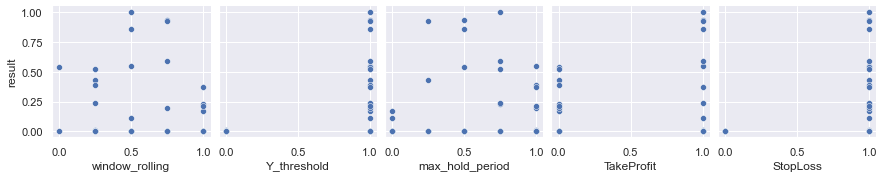

In [164]:
seaborn.set(rc={'figure.figsize': (11.7, 8.27)})
seaborn.pairplot(data=scaledPlot, x_vars=COLUMNS, y_vars=f"result")

In [165]:
# Понижаем размерность
pca = PCA(n_components = 2)
XPCAreduced = pca.fit_transform(scaledPlot.drop('result', axis=1).values)
pca.explained_variance_ratio_

array([0.26996527, 0.26489122])

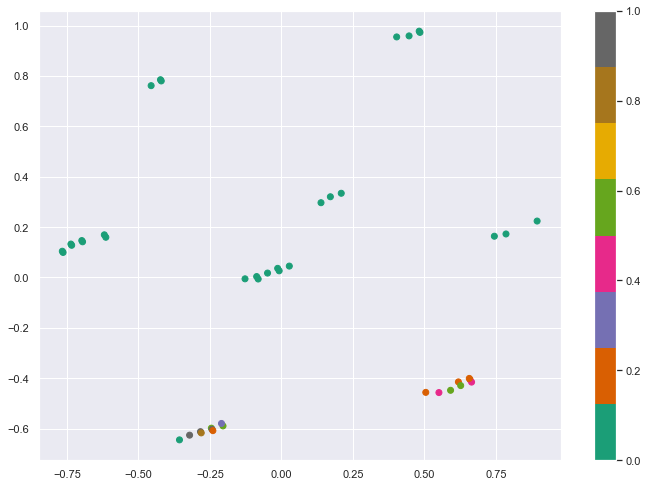

In [166]:
sc = plt.scatter(x=XPCAreduced.T[0], y=XPCAreduced.T[1], c=scaledPlot['result'], cmap='Dark2')
plt.colorbar(sc)

In [154]:
pca.explained_variance_ratio_

array([0.23924367, 0.21388557])

In [147]:
"------"
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, learning_rate='auto', init='random')
scaledTSNE = tsne.fit_transform(scaledPlot.drop('result', axis=1).values)
scaledTSNE.shape

(45, 2)

array([[-1.8326039 , -0.77084357, -3.847001  , -1.959482  , -4.3453293 ,
        -1.8589025 , -3.029519  , -2.0768754 , -3.581894  , -3.1638794 ,
        -2.695066  , -2.3454425 , -2.9852042 , -1.9308475 , -1.2959018 ,
        -3.2132852 , -3.4832313 , -3.1955538 , -4.639306  , -2.0404377 ,
        -2.0231903 , -4.4887967 , -2.0696356 , -3.9202147 , -3.1515954 ,
        -4.4012647 , -2.9959137 , -2.615188  , -3.7804198 , -2.0617924 ,
        -0.82991636, -3.8268254 , -0.7607219 , -1.2391658 , -3.4747617 ,
        -2.2537334 , -3.856002  , -0.7735109 , -1.3268365 , -2.6292148 ,
        -1.8465296 , -2.5398126 , -4.400222  , -2.522756  , -2.9226933 ],
       [-8.508052  , -6.841151  , -4.6943793 , -7.285391  , -5.3897405 ,
        -7.4435263 , -6.0523257 , -6.8894153 , -7.325056  , -6.4149733 ,
        -7.733811  , -5.080848  , -6.2846527 , -7.4661217 , -5.938141  ,
        -5.9979916 , -5.4642725 , -5.717246  , -6.3015532 , -6.6871862 ,
        -7.229019  , -6.043303  , -5.181923  , -7.

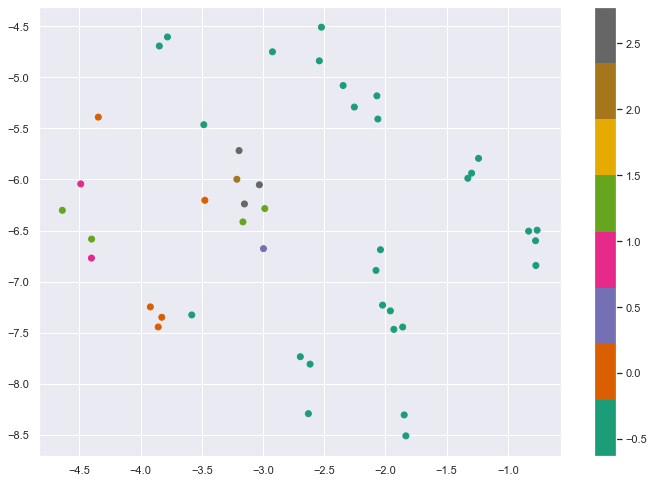

In [150]:
sc = plt.scatter(x=scaledTSNE.T[0], y=scaledTSNE.T[1], c=scaledPlot['result'], cmap='Dark2')
plt.colorbar(sc)

In [ ]:
# https://www.machinelearningmastery.ru/feature-extraction-techniques-d619b56e31be/

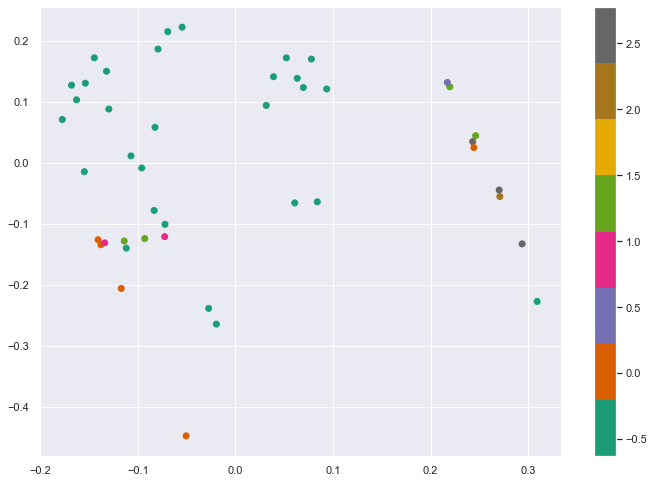

In [161]:
from sklearn.manifold import LocallyLinearEmbedding

embedding = LocallyLinearEmbedding(n_components=3)

X_lle = embedding.fit_transform(scaledPlot.drop('result', axis=1).values)
sc = plt.scatter(x=X_lle.T[1], y=X_lle.T[2], c=scaledPlot['result'], cmap='Dark2')
plt.colorbar(sc)